<a href="https://colab.research.google.com/github/zia207/r-colab/blob/main/NoteBook/Machine_Learning/Tree_based/03-01-02-08-02-tree-based-models-bagging-grf-causal-forest-r.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![alt text](http://drive.google.com/uc?export=view&id=1bLQ3nhDbZrCCqy_WCxxckOne2lgVvn3l)

# 2.8.2 Causal Forest (CF)

This tutorial provides an overview of **Causal Forests** (CF) within the Generalized Random Forests (GRF) framework, focusing on estimating heterogeneous treatment effects in observational or experimental data. It includes a step-by-step guide to implementing Causal Forests using the `{grf}` package in R, with practical examples and explanations tailored to the `lung` dataset from the `{survival}` package.

## Overview

A **Causal Forest** is a machine learning method within the Generalized Random Forests (GRF) framework, designed to estimate **heterogeneous treatment effects** in observational or experimental data studies. Specifically, it estimates the **Conditional Average Treatment Effect (CATE)**, which measures how the effect of a treatment varies across individuals based on their characteristics (covariates). It builds on the random forest algorithm but adapts it for causal inference, focusing on estimating causal effects rather than just predicting outcomes. Causal forests are particularly useful in fields like healthcare, economics, and social sciences, where understanding how different subgroups respond to treatments or interventions is crucial. They can handle complex interactions between covariates and treatment effects, making them a powerful tool for causal analysis.




### Key Concepts

-   `Treatment Effect`: The difference in outcomes between a treated and untreated state for an individual, often denoted as

$$ \tau(x) = E[Y(1) - Y(0) | X = x] $$

where:

-   $Y(1)$: Outcome if treated.

-   $Y(0)$: Outcome if not treated.

-   $X$: Covariates (e.g., age, sex, income).

-   $\tau(x)$: CATE, the expected treatment effect for individuals with covariates $X = x$.

-   `Heterogeneity`: Causal forests identify how treatment effects differ across subgroups defined by covariates (e.g., a drug may work better for older patients).

-   `Random Forest Foundation`: Like standard random forests, causal forests use an ensemble of decision trees, but the trees are constructed to optimize for treatment effect estimation rather than prediction accuracy.


### How Causal Forests Work

1.  Data Requirements

-   Outcome ($Y$): The variable of interest (e.g., survival time, test score).

-   Treatment ($W$): A binary or continuous variable indicating treatment status (e.g., 1 = treated, 0 = control).

-   Covariates ($X$) : Features that may influence the treatment effect (e.g., age, gender).

2.  Tree Construction

-   Each tree is grown on a random subset of the data and features, similar to random forests.

-   Splits are chosen to maximize **heterogeneity in treatment effects** rather than prediction accuracy. For example, a split might separate patients into groups where the treatment effect (difference in $Y$ between treated and control) is significantly different.

-   The splitting criterion often uses a measure like the variance of treatment effects or a modified mean squared error tailored o causal inference.

3.  Honest Estimation

-   To reduce overfitting, causal forests use “honest” estimation: one subset of data builds the tree structure (determines splits), and another subset estimates treatment effects within each leaf.

-   This ensures unbiased estimates of $\tau(x)$ within each subgroup defined by the tree.

4.  Aggregation

-   Treatment effect estimates from all trees are averaged to produce a robust estimate of $\tau(x)$ for each individual or covariate combination.

-   The forest provides a smooth, non-parametric estimate of how treatment effects vary with covariates.

5.  Output

-   CATE Estimates: $\tau(x)$, the estimated treatment effect for

-   each individual based on their covariates.

-   Average Treatment Effect (ATE): The average of $\tau(x)$ across the population, $E[\tau(X)]$.

-   Variable Importance: Identifies which covariates most influence heterogeneity in reatment effects.


## Setup R in Python Runtype

### Install {rpy2}

{rpy2} is a Python package that provides an interface to the R programming language, allowing Python users to run R code, call R functions, and manipulate R objects directly from Python. It enables seamless integration between Python and R, leveraging R's statistical and graphical capabilities while using Python's flexibility. The package supports passing data between the two languages and is widely used for statistical analysis, data visualization, and machine learning tasks that benefit from R's specialized libraries.

In [1]:
!pip uninstall rpy2 -y
!pip install rpy2==3.5.1
%load_ext rpy2.ipython

Found existing installation: rpy2 3.5.17
Uninstalling rpy2-3.5.17:
  Successfully uninstalled rpy2-3.5.17
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.7/201.7 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rpy2: filename=rpy2-3.5.1-cp311-cp311-linux_x86_64.whl size=314978 sha256=6b23b030d182b7f5f5d6227f09b1b3c37e03e280fd43fc0cbc3a0a5ca396d778
  Stored in directory: /root/.cache/pip/wheels/e9/55/d1/47be85a5f3f1e1f4d1e91cb5e3a4dcb40dd72147f184c5a5ef
Successfully built rpy2


### Mount Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Causal Forest (CF) with R

This tutorial demonstrats how to use the `{grf}` package in R to implement Causal Forest. We’ll use data from the `{survival}` package for consistency, specifically the `lung` dataset, which contains survival data for patients with advanced lung cancer. The tutorial includes code, explanations, and interpretations, tailored to each forest type.





### Load and Check Required Libraries

In [3]:
%%R
packages <- c('tidyverse',
              'plyr',
              'grf',
              'survival',
              'mlbench',
              'Metrics')

### Install Missing Packages

In [ ]:
%%R
# Install missing packages
new.packages <- packages[!(packages %in% installed.packages(lib='drive/My Drive/R/')[,"Package"])]
if(length(new.packages)) install.packages(new.packages, lib='drive/My Drive/R/')

### Verify Installation

In [4]:
%%R
# set library path
.libPaths('drive/My Drive/R')
# Verify installation
cat("Installed packages:\n")
print(sapply(packages, requireNamespace, quietly = TRUE))

Installed packages:
tidyverse      plyr       grf  survival   mlbench   Metrics 
     TRUE      TRUE      TRUE      TRUE      TRUE      TRUE 


### Load R Packages

In [5]:
%%R
# set library path
.libPaths('drive/My Drive/R')
# Load packages with suppressed messages
invisible(lapply(packages, function(pkg) {
  suppressPackageStartupMessages(library(pkg, character.only = TRUE))
}))


### Check Loaded Packages

In [6]:
%%R
# Check loaded packages
cat("Successfully loaded packages:\n")
print(search()[grepl("package:", search())])# Check loaded packageswer)

Successfully loaded packages:
 [1] "package:Metrics"   "package:mlbench"   "package:survival" 
 [4] "package:grf"       "package:plyr"      "package:lubridate"
 [7] "package:forcats"   "package:stringr"   "package:dplyr"    
[10] "package:purrr"     "package:readr"     "package:tidyr"    
[13] "package:tibble"    "package:ggplot2"   "package:tidyverse"
[16] "package:tools"     "package:stats"     "package:graphics" 
[19] "package:grDevices" "package:utils"     "package:datasets" 
[22] "package:methods"   "package:base"     


### Load and Preprocess the `lung` Dataset

In [7]:
%%R
data(lung, package = "survival")

# Remove missing values
lung_clean <- na.omit(lung)

# Define covariates (X), outcome (Y), and censoring indicator (D)
X <- lung_clean[, c("age", "sex", "ph.ecog", "ph.karno", "pat.karno", "meal.cal", "wt.loss")]
Y <- lung_clean$time  # Survival time in days
D <- ifelse(lung_clean$status == 2, 1, 0)  # 1 = event (dead), 0 = censored

# Simulate binary treatment variable (e.g., drug vs. placebo)
set.seed(123)
W <- rbinom(nrow(lung_clean), 1, 0.5 + 0.2 * (X$age > 60))  # Treatment biased toward older patients

### Convert Covariates to Numeric Matrix

In [8]:
%%R
# Convert X to a numeric matrix and ensure column names
X <- as.matrix(X)
# Explicitly set column names to avoid any issues
colnames(X) <- c("age", "sex", "ph.ecog", "ph.karno", "pat.karno", "meal.cal", "wt.loss")
cat("Column names of X:", colnames(X), "\n")
cat("Number of columns in X:", ncol(X), "\n")

# Remove columns with near-zero variance to prevent grf from dropping them
X <- X[, apply(X, 2, var) > 1e-10, drop = FALSE]
cat("Column names after variance check:", colnames(X), "\n")
cat("Number of columns after variance check:", ncol(X), "\n")

Column names of X: age sex ph.ecog ph.karno pat.karno meal.cal wt.loss 
Number of columns in X: 7 
Column names after variance check: age sex ph.ecog ph.karno pat.karno meal.cal wt.loss 
Number of columns after variance check: 7 


### Split Data into Training and Test Sets

In [9]:
%%R
# Split data into training (80%) and test (20%) sets
train_prop <- 0.8
n <- nrow(lung_clean)
train_idx <- sample(1:n, size = round(train_prop * n))
X_train <- X[train_idx, , drop = FALSE]
Y_train <- Y[train_idx]
W_train <- W[train_idx]
X_test <- X[-train_idx, , drop = FALSE]
Y_test <- Y[-train_idx]
W_test <- W[-train_idx]
cat("Training set size:", nrow(X_train), "\n")
cat("Test set size:", nrow(X_test), "\n")
cat("Column names of X_train:", colnames(X_train), "\n")

Training set size: 134 
Test set size: 33 
Column names of X_train: age sex ph.ecog ph.karno pat.karno meal.cal wt.loss 


### Train Causal Forest on Training Data

The `causal_forest()` function in the `grf` package in R is used to estimate heterogeneous treatment effects (Conditional Average Treatment Effects, CATE) using a causal forest, a specialized random forest for causal inference. Below is a concise overview of the most important arguments for the `causal_forest()` function, based on the `grf` package documentation (version 2.3.2, available at https://grf-labs.github.io/grf/). These arguments control the model’s behavior, estimation process, and performance tuning.

Below are the important arguments of `causal_forest()` function:

-   `X` (Required): Matrix of covariates (features) used to estimate heterogeneity in treatment effects. Each row is an observation, and each column is a covariate (e.g., age, sex).

-   `Y` (Required): Vector of observed outcomes (e.g., survival time, test score).

-   `W` (Required): Vector of treatment assignments (e.g., 1 = treated, 0 = control for binary treatment).

-   `num.trees` (Default: 2000): Number of trees in the forest.

-   `sample.fraction` (Default: 0.5): Fraction of data used to build each tree (subsampling rate).

-   `mtry` : Number of covariates considered for splitting at each node. If `NULL`, defaults to $\min(\lceil \sqrt{p} \rceil, \lceil p/3 \rceil)$, where $p$ is the number of covariates.

-   `min.node.size` (Default: 5): Minimum number of observations in each leaf node.

-   `honesty` (Default: TRUE): Whether to use honest splitting (separate data for tree structure and effect estimation).

-   `honesty.fraction` (Default: 0.5): Fraction of data used for honest estimation (when `honesty = TRUE`). The remaining fraction is used for tree structure.

-   `ci.group.size` (Default: 2): Number of trees grouped to compute variance estimates for confidence intervals.

-   `alpha` (Default: 0.05): Maximum imbalance allowed in treatment/control splits, controlling propensity score overlap.

-   `imbalance.penalty` (Default: 0): Penalty for imbalanced splits in treatment/control groups.

-   `stabilize.splits` (Default: TRUE): Whether to stabilize splits by enforcing balance in treatment/control groups.

-   `tune.parameters` (Default: "none"): Specifies whether to tune hyperparameters (e.g., `mtry`,`min.node.size`) via cross-validation. For more details, refer to the`grf` documentation (https://grf-labs.github.io/grf/) or ask for specific clarifications!

In [10]:
%%R
# Train causal forest
cf_model <- causal_forest(
  X = X_train,
  Y = Y_train,
  W = W_train,
  num.trees = 1000,
  sample.fraction = 0.5,
  mtry = min(ceiling(sqrt(ncol(X_train))), ncol(X_train)/3),
  min.node.size = 5,
  honesty = TRUE,
  honesty.fraction = 0.5,
  ci.group.size = 2,
  alpha = 0.05,
  imbalance.penalty = 0,
  stabilize.splits = TRUE,
  tune.parameters = "all",
  seed = 123
)

# Estimate ATE on training data
ate_train <- average_treatment_effect(cf_model, target.sample = "all")
cat("Training ATE:", ate_train["estimate"], "±", 1.96 * ate_train["std.err"], "(95% CI)\n")

Training ATE: -35.41114 ± 84.60876 (95% CI)


The **ATE** is the average treatment effect (in days of survival) across the training population, with a 95% confidence interval.

### Predict CATE on Test Data

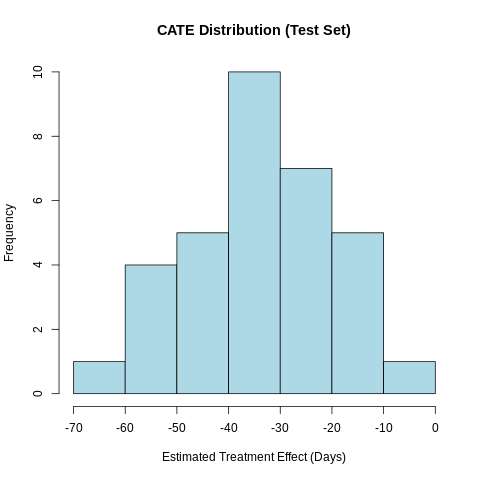

In [11]:
%%R
# Predict CATE on test set
cate_test_pred <- predict(cf_model, X_test)$predictions
hist(cate_test_pred, main = "CATE Distribution (Test Set)", xlab = "Estimated Treatment Effect (Days)", col = "lightblue")


### Variable Importance

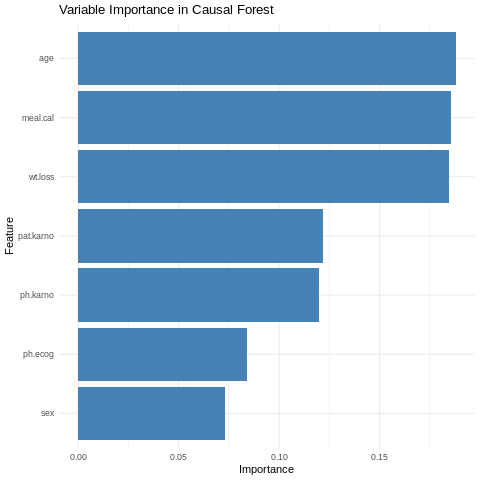

In [14]:
%%R
var_importance <- variable_importance(cf_model)
features <- colnames(X_train)

# Create a data frame for plotting
importance_df <- data.frame(
  Feature = features,
  Importance = var_importance
)

# Create bar plot with ggplot2
ggplot(importance_df, aes(x = reorder(Feature, Importance), y = Importance)) +
  geom_bar(stat = "identity", fill = "steelblue") +
  coord_flip() +  # Flip coordinates for better readability
  labs(title = "Variable Importance in Causal Forest",
       x = "Feature",
       y = "Importance") +
  theme_minimal()

### Rank-Weighted Average Treatment Effect (RATE)

The `rank_average_treatment_effect()` function in the {grf} package computes the AUTOC and provides a 95% confidence interval (CI) for it, allowing you to quantify the uncertainty of the treatment effect heterogeneity

In [13]:
%%R
#| fig.width: 5.5
#| fig.height: 5
# Calculate AUTOC on test set with priorities
# Create a subset index for the test set (1 to nrow(X_test))
test_subset <- seq_len(nrow(X_test))

autoc_result <- rank_average_treatment_effect(
  forest = cf_model,
  priorities = cate_test_pred,
  target = "AUTOC",
  subset = test_subset
)

# Extract AUTOC estimate and 95% CI
autoc_estimate <- autoc_result$estimate
autoc_std_err <- autoc_result$std.err
autoc_ci_lower <- autoc_estimate - 1.96 * autoc_std_err
autoc_ci_upper <- autoc_estimate + 1.96 * autoc_std_err
cat("AUTOC Estimate:", autoc_estimate, "\n")
cat("AUTOC 95% CI:", autoc_ci_lower, "to", autoc_ci_upper, "\n")

AUTOC Estimate: 65.19725 
AUTOC 95% CI: -89.42004 to 219.8145 


## Summary and Conclusion

Causal Forests are a powerful tool for estimating heterogeneous treatment effects in observational or experimental data. They extend the random forest framework to focus on causal inference, allowing researchers to understand how treatment effects vary across individuals based on their characteristics. The `grf` package in R provides a robust implementation of causal forests, enabling users to estimate Conditional Average Treatment Effects (CATE) and visualize treatment effect heterogeneity effectively. This tutorial demonstrated how to implement a causal forest using the `lung` dataset, including data preprocessing, model training, prediction, variable importance analysis, and estimation of the Average Treatment Effect (ATE) and Rank-Weighted Average Treatment Effect (RATE).

## References

1.  Athey, Susan, Julie Tibshirani, and Stefan Wager. "Generalized Random Forests". Annals of Statistics, 47(2), 2019.

2.  Wager, Stefan, and Susan Athey. "Estimation and Inference of Heterogeneous Treatment Effects using Random Forests". Journal of the American Statistical Association, 113(523), 2018.

3.  Nie, Xinkun, and Stefan Wager. "Quasi-Oracle Estimation of Heterogeneous Treatment Effects". Biometrika, 108(2), 2021.

4.  [grf Causal Forest documentation](https://grf-labs.github.io/grf/reference/causal_forest.html#references)

